## Install the package dependencies before running this notebook

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import os, os.path 
import numpy as np
import pickle
from glob import glob
import matplotlib.pyplot as plt
from ArgoDataset import ArgoverseDataset, get_city_trajectories, show_sample_batch

"""
    number of trajectories in each city
    # austin --  train: 43041 test: 6325 
    # miami -- train: 55029 test:7971
    # pittsburgh -- train: 43544 test: 6361
    # dearborn -- train: 24465 test: 3671
    # washington-dc -- train: 25744 test: 3829
    # palo-alto -- train:  11993 test:1686

    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds
    
"""
cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
splits = ["train", "validation", "test"]

## Create a Torch.Dataset class for the training dataset

In [2]:
def transform(data):
    # currently 109 input - 109 out
    inp = np.concatenate((data[0], data[1][:-1]))
    out = np.concatenate((data[0][1:], data[1]))

    return (inp, out)

In [3]:
dataset = ArgoverseDataset(city = "all", split = "train")#, transform=transform)
train_dataset, val_dataset = dataset.split()
print(train_dataset[0][0])

(203816, 50, 6)
[[ 0.00000000e+00  0.00000000e+00 -3.17220166e-01 -1.17144065e-02
  -7.09512735e-02 -2.38705205e-03]
 [-3.17220166e-01 -1.17144065e-02 -3.88171440e-01 -1.41014586e-02
  -6.76939546e-02 -2.22825636e-03]
 [-7.05391606e-01 -2.58158651e-02 -4.55865394e-01 -1.63297150e-02
  -6.20383687e-02 -2.00194639e-03]
 [-1.16125700e+00 -4.21455801e-02 -5.17903763e-01 -1.83316613e-02
  -5.36198805e-02 -1.65126161e-03]
 [-1.67916076e+00 -6.04772414e-02 -5.71523644e-01 -1.99829230e-02
  -4.28761101e-02 -1.30075644e-03]
 [-2.25068441e+00 -8.04601644e-02 -6.14399754e-01 -2.12836794e-02
  -3.09527442e-02 -1.26339975e-03]
 [-2.86508416e+00 -1.01743844e-01 -6.45352498e-01 -2.25470791e-02
  -1.50205534e-02 -6.29700434e-04]
 [-3.51043666e+00 -1.24290923e-01 -6.60373051e-01 -2.31767796e-02
   5.05665145e-03  3.75777993e-05]
 [-4.17080971e+00 -1.47467703e-01 -6.55316400e-01 -2.31392018e-02
   2.74785855e-02  5.83188015e-04]
 [-4.82612611e+00 -1.70606904e-01 -6.27837814e-01 -2.25560138e-02
   1.0344

# Model Constants

In [4]:
batch_sz = 32  # batch size
input_size = 6
hidden_size = 128
output_size = 6
dropout = 0.5
inp_seq_len = 50
num_epochs = 5#15
num_base_epochs = 5
lr = 1e-4
lr_spec = 5e-6

# Baseplate Model

In [6]:
from models import Conv2Seq
from tqdm import tqdm

city_loss_all=dict()
print("Training model baseplate")
train_loader = DataLoader(train_dataset, batch_size = batch_sz, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size=batch_sz*2, shuffle=True)
val_iter = iter(val_loader)

BEST_PATH = "./models/all_best_conv.pt"
PATH = "./models/baseplate_conv.pt"
best_err = 10000000000

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

rnn = Conv2Seq(input_size, hidden_size, output_size, dropout, device).cuda()
criterion = torch.nn.MSELoss()
criterion.to(device)
opt = torch.optim.Adam(rnn.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=40)
# scheduler = torch.optim.lr_scheduler.StepLR(opt, 20, gamma=0.5)

print_every = 1000
val_every = 8
plot_every = 500 / (batch_sz/4)
train_loss = 0
val_loss = 0
train_losses = [-1]
val_losses = [-1]
# fig = plt.figure()

rnn.train()
for epoch in range(num_base_epochs):
    current_loss = 0
    val_iter = iter(val_loader)
    for s_num, (x, y) in tqdm(enumerate(train_loader), \
                              "val_loss: %.3f, best_val: %.3f, train_loss: %.3f, epoch #%d" % (val_losses[-1], best_err, train_losses[-1], epoch)):
        x, y = x.to(torch.float32).to(device), y.to(torch.float32).to(device)

        opt.zero_grad()
        loss = 0

        y_hat = rnn(x, y)
        loss = criterion(y_hat[:, :, :2], y[:, :, :2]) \
                + criterion(y_hat[:, :, 2:4], y[:, :, 2:4]) \
                + criterion(y_hat[:, :, 4:6], y[:, :, 4:6])

        loss.backward()
        opt.step()

        # Validate every so often
        if s_num % val_every == 0:
            with torch.no_grad():
                rnn.eval()
                vx, vy = next(val_iter)
                vx, vy = vx.to(torch.float32).to(device), vy.to(torch.float32).to(device)
                vy_hat = rnn(vx)
                val_loss += criterion(vy_hat[:, :, :2], vy[:, :, :2]) \
                        + criterion(vy_hat[:, :, 2:4], vy[:, :, 2:4]) \
                        + criterion(vy_hat[:, :, 4:6], vy[:, :, 4:6])
                del vx
                del vy
                rnn.train()

        # Keep track of average losses
        current_loss += loss.item()
        if s_num != 0 and s_num % plot_every == 0:
            with torch.no_grad():
                train_losses.append(current_loss / plot_every)
                current_loss = 0
                val_losses.append(val_loss / plot_every)
                val_loss = 0
            if val_losses[-1] < best_err:
                torch.save(rnn, BEST_PATH)
                best_err = val_losses[-1]
            scheduler.step(val_losses[-1])
        del x
        del y

city_loss_all["train"] = train_losses
city_loss_all["val"] = val_losses
torch.save(rnn, PATH)

Training model baseplate


val_loss: -1.000, best_val: 10000000000.000, train_loss: -1.000, epoch #0: 5096it [14:16,  5.95it/s]
val_loss: 137.599, best_val: 137.599, train_loss: 844.650, epoch #1: 5096it [15:01,  5.66it/s]
val_loss: 60.121, best_val: 60.121, train_loss: 247.945, epoch #2: 5096it [14:41,  5.78it/s]
val_loss: 32.957, best_val: 32.957, train_loss: 72.779, epoch #3: 5096it [14:34,  5.83it/s]
val_loss: 23.945, best_val: 21.074, train_loss: 18.877, epoch #4: 5096it [14:37,  5.80it/s]


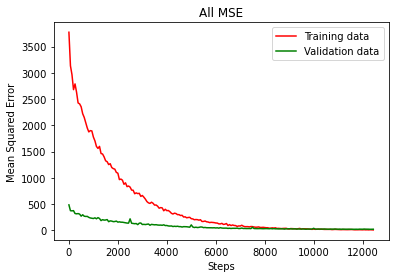

In [14]:
plt.figure()
plt.plot(np.array(range(len(city_loss_all["train"][1:])))*plot_every, city_loss_all["train"][1:],'-r', label="Training data")
plt.plot(np.array(range(len(city_loss_all["val"][1:])))*plot_every, city_loss_all["val"][1:],'-g', label="Validation data")
plt.gca().set_xlabel("Steps")
plt.gca().set_ylabel("Mean Squared Error")
plt.gca().set_title("All MSE")
plt.legend()
plt.show()

tensor(27.8829, device='cuda:0')


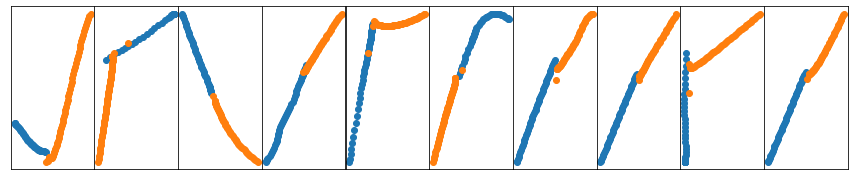

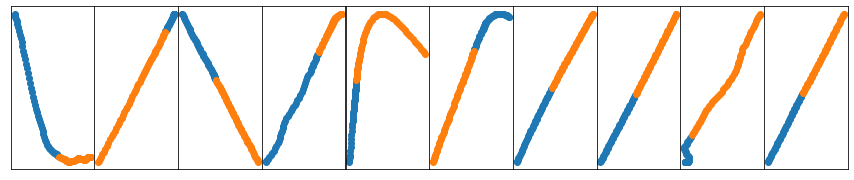

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
with torch.no_grad():
    rnn = torch.load(f"./models/baseplate_conv.pt").to(device)
    rnn.eval()
#     val_dataset = ArgoverseDataset(city = "all", split = "validation")
    val_loader = DataLoader(val_dataset, batch_size=batch_sz*2, shuffle=True)
    x, y = next(iter(val_loader))
    x, y = x.to(torch.float32).to(device), y.to(torch.float32).to(device)
    y_hat = rnn(x[:, :inp_seq_len])
    loss = torch.nn.MSELoss()
    print(loss(y_hat, y))
    show_sample_batch((x[0:10, :inp_seq_len].cpu(), y_hat.cpu()[0:10]))
    show_sample_batch((x[0:10, :inp_seq_len].cpu(), y[0:10].cpu()))
    plt.show()

# Model Training

In [6]:
# from models import LSTM
# from tqdm import tqdm

# city_loss = dict()

# for city in cities:
#     city_loss[city]=dict()
#     print(f"Training model for {city}")
#     dataset = ArgoverseDataset(city = city, split = "train")#, transform=transform)
#     train_dataset, val_dataset = dataset.split()
#     train_loader = DataLoader(train_dataset, batch_size = batch_sz, shuffle = True)
#     val_loader = DataLoader(val_dataset, batch_size=batch_sz*2, shuffle=True)
#     val_iter = iter(val_loader)

#     BEST_PATH = f"./models/{city}_best_attn.pt"
#     PATH = f"./models/{city}_attn.pt"
#     best_err = 10000000000

#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# #     rnn = LSTM(input_size, hidden_size, output_size, dropout, device).cuda()
#     rnn = torch.load(f"./models/baseplate_attn.pt").to(device)
#     criterion = torch.nn.MSELoss()
#     criterion.to(device)
#     opt = torch.optim.Adam(rnn.parameters(), lr=lr)
#     scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt)
#     # scheduler = torch.optim.lr_scheduler.StepLR(opt, 20, gamma=0.5)

#     print_every = 1000
#     val_every = 8
#     plot_every = 500 / (batch_sz/4)
#     train_loss = 0
#     val_loss = 0
#     train_losses = [-1]
#     val_losses = [-1]
#     # fig = plt.figure()

#     rnn.train()
#     for epoch in range(num_epochs):
#         current_loss = 0
#         val_iter = iter(val_loader)
#         for s_num, (x, y) in tqdm(enumerate(train_loader), \
#                                   "val_loss: %.3f, best_val: %.3f, train_loss: %.3f, epoch #%d" % (val_losses[-1], best_err, train_losses[-1], epoch)):
#             x, y = x.to(torch.float32).to(device), y.to(torch.float32).to(device)

#             opt.zero_grad()
#             loss = 0

#             y_hat = rnn(x)
#             loss = criterion(y_hat, y)

#             loss.backward()
#             opt.step()

#             # Validate every so often
#             if s_num % val_every == 0:
#                 with torch.no_grad():
#                     rnn.eval()
#                     vx, vy = next(val_iter)
#                     vx, vy = vx.to(torch.float32).to(device), vy.to(torch.float32).to(device)
#                     vy_hat = rnn(vx)
#                     val_loss += criterion(vy_hat, vy)
#                     del vx
#                     del vy
#                     rnn.train()

#             # Keep track of average losses
#             current_loss += loss.item()
#             if s_num != 0 and s_num % plot_every == 0:
#                 with torch.no_grad():
#                     train_losses.append(current_loss / plot_every)
#                     current_loss = 0
#                     val_losses.append(val_loss / plot_every)
#                     val_loss = 0
#                 if val_losses[-1] < best_err:
#                     torch.save(rnn, BEST_PATH)
#                     best_err = val_losses[-1]
#                 scheduler.step(val_losses[-1])
#             del x
#             del y
            
#     city_loss[city]["train"] = train_losses
#     city_loss[city]["val"] = val_losses
#     torch.save(rnn, PATH)

#     del rnn
#     del criterion
#     del scheduler
#     del opt
        

In [7]:
# for i, city in enumerate(city_loss):
#     plt.figure(i)
#     plt.plot(np.array(range(len(city_loss[city]["train"][1:])))*plot_every, city_loss[city]["train"][1:],'-r', label="Training data")
#     plt.plot(np.array(range(len(city_loss[city]["val"][1:])))*plot_every, city_loss[city]["val"][1:],'-g', label="Validation data")
#     plt.gca().set_xlabel("Steps")
#     plt.gca().set_ylabel("Mean Squared Error")
#     plt.gca().set_title(f"{city} MSE")
#     plt.legend()
#     plt.show()

In [8]:
# with torch.no_grad():
#     for city in city_loss:
#         rnn = torch.load(f"./models/{city}_best.pt").to(device)
#         rnn.eval()
#         val_dataset = ArgoverseDataset(city = city, split = "validation")
#         val_loader = DataLoader(val_dataset, batch_size=batch_sz*2, shuffle=True)
#         x, y = next(iter(val_loader))
#         x, y = x.to(torch.float32).to(device), y.to(torch.float32).to(device)
#         y_hat = rnn(x[:, :inp_seq_len])
#         loss = torch.nn.MSELoss()
#         print(loss(y_hat, y))
#         show_sample_batch((x[0:5, :inp_seq_len].cpu(), y_hat.cpu()[0:5]))
# #         del rnn
# #         rnn = torch.load(f"./models/{city}.pt").to(device)
# #         rnn.eval()
# #         y_hat = rnn(x[:, :inp_seq_len])
# #         loss = torch.nn.MSELoss()
# #         print(loss(y_hat, y))
# #         show_sample_batch((x[0:10, :inp_seq_len].cpu(), y_hat.cpu()[0:10]))
#         show_sample_batch((x[0:5, :inp_seq_len].cpu(), y[0:5, :].cpu()))
#         plt.show()
#         del rnn

# Examining the submission format

In [9]:
import pandas as pd

In [10]:
sample_sub = pd.read_csv('./argo2/sample_submission.csv')
sample_sub.head()

,ID,v0,v1,v2,v3,v4,v5,v6,v7,v8,...,v110,v111,v112,v113,v114,v115,v116,v117,v118,v119
0,0_austin,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1_austin,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2_austin,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3_austin,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4_austin,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
# %load_ext autoreload
# %autoreload 2

Processing city austin
(6325, 50, 2)
(6325, 50, 6)
(6325, 60, 6)
(6325, 60, 2)
(6325, 120)
[  27.86433403 -580.02025069]
Processing city miami
(7971, 50, 2)
(7971, 50, 6)


RuntimeError: CUDA out of memory. Tried to allocate 2.82 GiB (GPU 0; 10.76 GiB total capacity; 5.60 GiB already allocated; 2.48 GiB free; 6.95 GiB reserved in total by PyTorch)

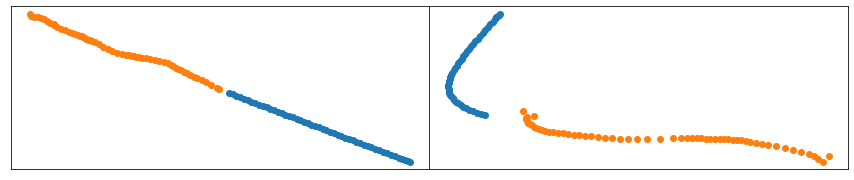

In [3]:
device = torch.device("cuda")

num_pred_steps = 60
all_preds = np.zeros(shape=(0, num_pred_steps * 2))
city_col = np.array([])
rnn = torch.load("./models/baseplate_attn.pt").to(device)
for city_name in cities:

    print("Processing city", city_name)
#     rnn = torch.load(f"./models/baseplate_attn.pt").to(device)
    rnn.eval()
    test_traj_in, test_traj_out = get_city_trajectories(city=city_name, split="test")
    print(test_traj_in.shape)
#   normal_traj = np.zeros(shape=test_traj_in.shape)
    normal_traj  = ArgoverseDataset(city = city_name, split = "test").inputs

    starts = test_traj_in[:,0]

    traj = torch.from_numpy(normal_traj).to(torch.float32).to(device)
    test_pred_arr = rnn(traj).cpu().detach().numpy()
    print(test_pred_arr.shape)
    
    test_pred_arr = test_pred_arr[:,:,:2]
    print(test_pred_arr.shape)
    
    for i in range(test_traj_in.shape[0]):
        test_pred_arr[i]+=starts[i]
    
 
    
    test_pred_arr_reshaped = np.reshape(test_pred_arr, newshape=(test_traj_in.shape[0], num_pred_steps * 2))
    print(test_pred_arr_reshaped.shape)

    all_preds = np.r_[all_preds, test_pred_arr_reshaped]
    city_col = np.r_[city_col, [str(i) + "_" + city_name for i in range(test_pred_arr.shape[0])]]
    print(test_traj_in[0][0])
    show_sample_batch((torch.tensor(test_traj_in[0:2]), torch.tensor(test_pred_arr[0:2])))
    del traj
    
#     del rnn
del rnn

In [18]:
import pandas as pd
sub_df = pd.DataFrame(np.c_[city_col, all_preds], columns=[np.r_[["ID"], ["v" + str(i) for i in range(120)]]])
sub_df.to_csv('./submissions/baseplate_attn_3lyr.csv', index=None)